# Heatmap: COVID-19 Age-Standardized Mortality Rates of Philippine Provinces

The objective of this notebook is to produce a heatmap of the age-standardized mortality rates of the Philippine provinces.

In [81]:
import geopandas as gpd
import pandas as pd
from shapely.ops import unary_union
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
sns.set_context("paper")

In [4]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/SMSL/COVID-19 Mortality Rates

Mounted at /content/drive
/content/drive/My Drive/SMSL/COVID-19 Mortality Rates


## Exploratory Data Analysis

In [52]:
gis = gpd.read_file("data/GIS/Copy of Provinces.shp")
gis.head()

,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM_ID,UPDATED,PERIMETER,AREA,LONGITUDE,LATITUDE,geometry
0,Abra,PH140100000,Cordillera Administrative Region,PH140000000,140100000,2019-12-31,286873.674,3.926646e+09,120.803,17.578,"POLYGON ((120.96109 17.95348, 120.97201 17.946..."
1,Agusan del Norte,PH160200000,Region XIII,PH160000000,160200000,2019-12-31,405415.597,2.676076e+09,125.536,9.031,"MULTIPOLYGON (((125.58886 9.45793, 125.59687 9..."
2,Agusan del Sur,PH160300000,Region XIII,PH160000000,160300000,2019-12-31,576475.959,8.452327e+09,125.729,8.422,"POLYGON ((125.88961 8.98195, 125.88896 8.96446..."
3,Aklan,PH060400000,Region VI,PH060000000,60400000,2019-12-31,507945.150,1.684872e+09,122.248,11.610,"MULTIPOLYGON (((122.43980 11.59717, 122.43979 ..."
4,Albay,PH050500000,Region V,PH050000000,50500000,2019-12-31,712200.986,2.469560e+09,123.616,13.210,"MULTIPOLYGON (((123.92676 13.12137, 123.92676 ..."


In [54]:
mortality_rates = pd.read_excel("output/mortality_rates.xlsx", index_col=0)
mortality_rates.head()

,crude per 100k,age-standardized per 100k
ABRA,62.322969,47.368369
AGUSAN DEL NORTE,78.587174,77.397950
AGUSAN DEL SUR,45.122501,50.589968
AKLAN,41.110304,33.988423
ALBAY,27.029981,25.471226


In [55]:
# provinces in the gis file
for province in gis['ADM2_EN'].str.upper():
    if province not in mortality_rates.index:
        print(province)

COTABATO
NCR, CITY OF MANILA, FIRST DISTRICT
NCR, FOURTH DISTRICT
NCR, SECOND DISTRICT
NCR, THIRD DISTRICT
SAMAR


In [56]:
for province in mortality_rates.index:
    if province not in gis['ADM2_EN'].str.upper().values:
        print(province)

COTABATO (NORTH COTABATO)
NCR
SAMAR (WESTERN SAMAR)


Resolve:
1. Rename provinces in the gis file
2. Merge NCR districts

In [57]:
# Adding a new column
gis['province'] = gis['ADM2_EN'].str.upper()

# setting province as the new index
gis = gis.set_index('province')

# Renaming index
gis = gis.rename(index={
    'SAMAR': 'SAMAR (WESTERN SAMAR)',
    'COTABATO': 'COTABATO (NORTH COTABATO)',
})

In [58]:
for province in mortality_rates.index:
    if province not in gis.index:
        print(province)

NCR


In [59]:
# Merging the 4 districts of NCR into one
gis.loc['NCR', 'geometry'] = unary_union(gis[gis['ADM2_EN'].apply(lambda x: 'NCR' in x)]['geometry'])

In [60]:
# Dropping the four districts of NCR
gis = gis.drop([
  'NCR, SECOND DISTRICT',
  'NCR, THIRD DISTRICT',
  'NCR, FOURTH DISTRICT',
  'NCR, CITY OF MANILA, FIRST DISTRICT'
])

In [62]:
for province in mortality_rates.index:
    if province not in gis.index:
        print(province)

In [63]:
for province in gis.index:
    if province not in mortality_rates.index:
        print(province)

In [64]:
gis = gis.reset_index()
gis.head()

,province,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM_ID,UPDATED,PERIMETER,AREA,LONGITUDE,LATITUDE,geometry
0,ABRA,Abra,PH140100000,Cordillera Administrative Region,PH140000000,140100000.0,2019-12-31,286873.674,3.926646e+09,120.803,17.578,"POLYGON ((120.96109 17.95348, 120.97201 17.946..."
1,AGUSAN DEL NORTE,Agusan del Norte,PH160200000,Region XIII,PH160000000,160200000.0,2019-12-31,405415.597,2.676076e+09,125.536,9.031,"MULTIPOLYGON (((125.58886 9.45793, 125.59687 9..."
2,AGUSAN DEL SUR,Agusan del Sur,PH160300000,Region XIII,PH160000000,160300000.0,2019-12-31,576475.959,8.452327e+09,125.729,8.422,"POLYGON ((125.88961 8.98195, 125.88896 8.96446..."
3,AKLAN,Aklan,PH060400000,Region VI,PH060000000,60400000.0,2019-12-31,507945.150,1.684872e+09,122.248,11.610,"MULTIPOLYGON (((122.43980 11.59717, 122.43979 ..."
4,ALBAY,Albay,PH050500000,Region V,PH050000000,50500000.0,2019-12-31,712200.986,2.469560e+09,123.616,13.210,"MULTIPOLYGON (((123.92676 13.12137, 123.92676 ..."


## Visualization

In [69]:
mortality_rates = mortality_rates.reset_index().rename(columns={"index": "province"})
mortality_rates.head()

,province,crude per 100k,age-standardized per 100k
0,ABRA,62.322969,47.368369
1,AGUSAN DEL NORTE,78.587174,77.397950
2,AGUSAN DEL SUR,45.122501,50.589968
3,AKLAN,41.110304,33.988423
4,ALBAY,27.029981,25.471226


In [70]:
merged_data = gis.merge(mortality_rates, on='province')
merged_data.head()

,province,ADM2_EN,ADM2_PCODE,ADM1_EN,ADM1_PCODE,ADM_ID,UPDATED,PERIMETER,AREA,LONGITUDE,LATITUDE,geometry,crude per 100k,age-standardized per 100k
0,ABRA,Abra,PH140100000,Cordillera Administrative Region,PH140000000,140100000.0,2019-12-31,286873.674,3.926646e+09,120.803,17.578,"POLYGON ((120.96109 17.95348, 120.97201 17.946...",62.322969,47.368369
1,AGUSAN DEL NORTE,Agusan del Norte,PH160200000,Region XIII,PH160000000,160200000.0,2019-12-31,405415.597,2.676076e+09,125.536,9.031,"MULTIPOLYGON (((125.58886 9.45793, 125.59687 9...",78.587174,77.397950
2,AGUSAN DEL SUR,Agusan del Sur,PH160300000,Region XIII,PH160000000,160300000.0,2019-12-31,576475.959,8.452327e+09,125.729,8.422,"POLYGON ((125.88961 8.98195, 125.88896 8.96446...",45.122501,50.589968
3,AKLAN,Aklan,PH060400000,Region VI,PH060000000,60400000.0,2019-12-31,507945.150,1.684872e+09,122.248,11.610,"MULTIPOLYGON (((122.43980 11.59717, 122.43979 ...",41.110304,33.988423
4,ALBAY,Albay,PH050500000,Region V,PH050000000,50500000.0,2019-12-31,712200.986,2.469560e+09,123.616,13.210,"MULTIPOLYGON (((123.92676 13.12137, 123.92676 ...",27.029981,25.471226


<ipython-input-90-dcfbd2d93166>:7: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(bar_info, shrink=0.25)


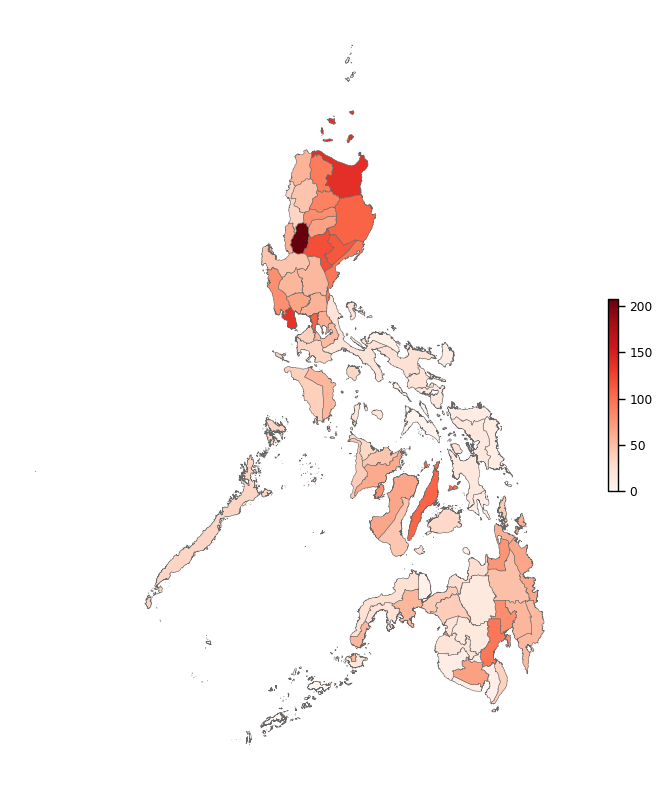

In [90]:
fig, ax = plt.subplots(1, figsize=(10, 10))
merged_data.plot(column="age-standardized per 100k", cmap="Reds", linewidth=0.4, ax=ax, edgecolor=".4")
bar_info = plt.cm.ScalarMappable(cmap="Reds", norm=plt.Normalize(vmin=0, vmax=merged_data['age-standardized per 100k'].max()))
bar_info._A = []
cbar = fig.colorbar(bar_info, shrink=0.25)
ax.axis("off")
fig.savefig('output/heatmap.png', dpi=300, transparent=False, bbox_inches='tight')